In [175]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import copy
import time

# The configuration model of Random Graphs

The objective of this project is the analysis of the configuration model for random graphs of given degree distribution. It follows the analysis given in the lectures for finite connetivity random graphs. To have a well defined setting, our graphs of $N$ vertices have the simple degree disribution $p_1 = 1 - \pi$, $p_4 = \pi$, i.e. a fraction $\pi \in [0,1]$ of vertices have degree four, the other vertiches have degree one. Note that this graph consists of $N/2$ isolated dimers in the case $\pi = 0$, and it is a 4-regular graph for $\pi = 1$.

**Some notations** : $M$ is the number of edges in the graph and $k_i$ is the degree of the vertex $i$.

## Problem 1: Generation of random graphs of given degree distribution

*Implement the algorithm for generating graphs of given vertex number and vertex degree distribution. Use the (slightly biased) version of the algorithm presented in the lectures, which does not accept multiple edges and self-edges. Think about a good data structure, which allows to efficiently address the following question.*

The algorithm simply goes as presented below:
- Generate $V = {1,...,N}$ vertices, each of one with $k_i$ half-edges.
- Randomly select pairs of half-edges and connect them by edges: $|E| = M = \frac{1}{2}\sum_{i=1}^N k_i$
We add the condition that multiple edges and self-edges are forbidden. One has to keep in mind that it might lead to a slightly biased version of the graphs.

*Note: the difference in properties between configuration models that allow self-edges and multiedges and the ones that do not results in a correction of order $1/N$ in analytical results. This error tends to zero as the network goes larger and larger*

In [2]:
def generate_graph(N, pi, max_iter, vocal = False):
    
    M = np.zeros((N,N))
    
    # Generate vertex degree distribution
    degree_dist = np.zeros(N)
    for i in range(N):
        random_number = np.random.rand()
        if random_number < pi:
            degree_dist[i] = 4
        else:
            degree_dist[i] = 1
    
    half_edges = np.copy(degree_dist) # list of remaining half-edges to link
    nb_iter = 0
    
    while np.sum(half_edges) > 0:
        
        x = np.random.randint(N)
        y = np.random.randint(N)
        
        if x != y and M[x,y] == 0: # to avoid self-edges and mutiple edges
            if half_edges[x] > 0 and half_edges[y] > 0: # if x and y still have to be linked
                M[x,y] += 1
                M[y,x] += 1
                half_edges[x] -= 1
                half_edges[y] -= 1
                nb_iter = 0
            else:
                nb_iter += 1 # so we can leave the loop if no edge has been added during the last "max_iter" steps
        else:
            nb_iter += 1
                
        if nb_iter == max_iter:
            if vocal is True:
                print('No edge has been added for the last',max_iter,'steps. The resulting graph does not respect strictly the desired vertex degree distribution')
            break
            
    return M   

Let's generate an example with a graph such as $N = 15$ and $\pi = 0.5$. We stop growing the graph if no edge has been added during the last 20 000 steps. The graph is stored in a $N \times N$ matrix whose indice $(i,j)$ gives the number of edges linking the vertex $i$ to the vertex $j$. $M$ is the symmetric adjacency matrix.

In [207]:
M = generate_graph(15,0.5,20000)

The generating vertex degree distribution is the following:

In [208]:
np.sum(M, axis = 1)

array([ 1.,  4.,  1.,  1.,  4.,  1.,  4.,  1.,  1.,  1.,  4.,  4.,  4.,
        4.,  1.])

Let's draw the resulting graph.

In [3]:
def show_graph(matrix,S=[]):
    plt.figure(figsize=(8,8))
    M = np.array(matrix)
    rows, cols = np.where(M == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    if len(S) > 0:
        nx.draw_networkx(gr, node_size=500, node_color=S, cmap = 'bwr')
    else:
        nx.draw_networkx(gr, node_size=500)
    plt.show()

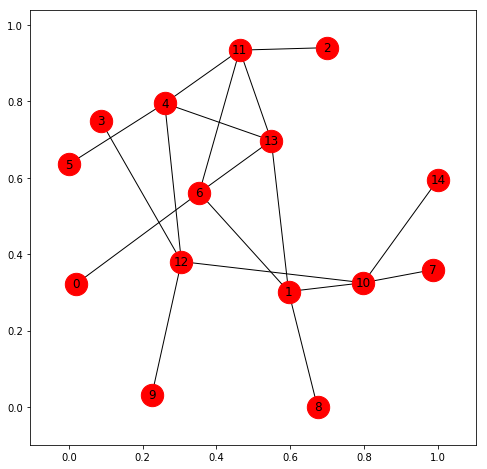

In [213]:
show_graph(M)

The drawing confirms that each node has either 1 or 4 edges. We can also try to generate some special cases with respectively $\pi = 0$ and $\pi = 1$.

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


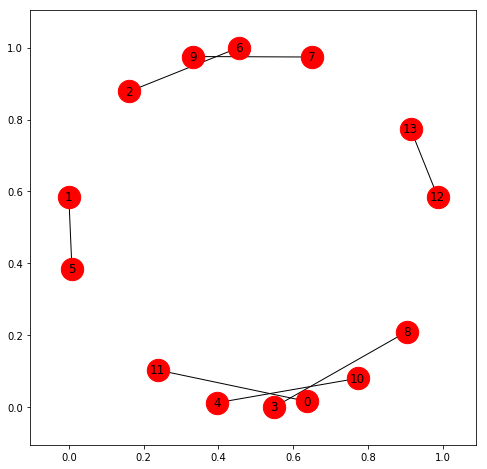

In [214]:
N = generate_graph(14,0,10000)
print(np.sum(N, axis = 1))
show_graph(N)

[ 4.  4.  4.  4.  4.  4.  3.  4.  3.  4.  4.  4.  4.  4.]


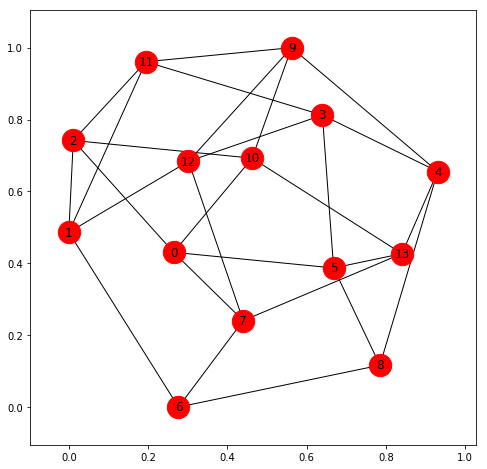

In [215]:
O = generate_graph(14,1,10000)
print(np.sum(O, axis = 1))
show_graph(O)

## Problem 2: Emergence of the giant component

*(a) Generalize the determination of the size of the giant component from random graphs in $G(N,c/N)$ to the configuration model. Determine the critical value of $\pi$, at which the giant component emerges.*

* A vertex $A$ does not belong to the giant component $C$ if and only if it is not connected to the giant component via any of its neighbors. Let's note $u$, the *average* probability that a vertex is not connected to $C$ via its connection to one neighboring vertex. Thus, if $A$ has $k$ neighbors, then the probability that it is not connected to $C$ via *any* of its neighbors is $u^k$. Hence the probability over the whole network, i.e. the average probability that a vertex is not in the giant component, is $P = \sum_k p_k u^k$ where $p_k$ is the fraction of vertices with $k$ neighbors in the graph. We note $g_0$ the generative function for the degree distribution i.e. $$g_0(z) = \sum_k p_k z^k$$
Then $P = g_0(u)$.

We deduce that the size $S$ of the giant component (i.e. the fraction of the graph belonging to the giant component) is $S = 1 - P = 1 - g_0(u)$.

Let's now find out $u$. The probability that a vertex does not belong to the giant component via one particular neighbor is equal to the probability that the latter vertex is not connected to $C$ via any of its other neigbors. If it has $k$ neighbors, the the probability is (again) $u^k$. Now, since we are dealing with a neighboring vertex, we have to take into account the excess degree distribution $q_k$, thus, by taking the average (by definition of $u$, see above):

$$u = \sum_k q_k u^k$$

If we note $g_1$, the generative function for the excess degree distribution i.e. $g_1(z) = \sum_k q_k z^k$, we have:
$$u = g_1(u)$$.


* We can now compute the size of the giant component by computing the fixed point of $g_1$ and insering it in $g_0$.
In our example with $p_1 = 1 - \pi$ and $p_4 = \pi$. We have $g_0(z) = p_1 z + p_4 z^4 = (1 - \pi)z + \pi z^4$ and $g_1(z) = \frac{g'_0(z)}{g'_0(1)} = \frac{1 - \pi + 4\pi z^3}{1 - \pi + 4\pi} = \frac{1 - \pi + 4\pi z^3}{1 + 3\pi}$.

We need to solve $g_1(u) = u$ i.e. $4\pi u^3 -u(1+3\pi) + 1 - \pi = 0$. $u = 1$ is an obvious solution so the polynom can actually be factorized to $4\pi(u - 1)(u^2 + u + \frac{\pi - 1}{4 \pi}) = 0$. This equation always has a solution for $\pi \in [0,1]$ and the only positive one is $u = -\frac{1}{2} + \frac{1}{2} \sqrt{\frac{1}{\pi}}$. Imposing the condition $u \in [0,1]$ (since $u$ is a probability) gives the critic $\pi_c = 1/9$. For $\pi$ values higher than $\pi_c$, the giant component exists in the graph.

* We can in turn deduce the size of the giant component as a function of $\pi$ by using $S = 1 - g_0(u)$ and the solution found just above.

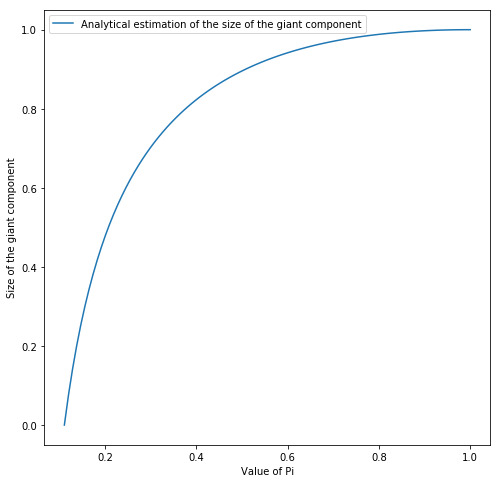

In [51]:
pi_list = np.linspace(1/9,1,100)
u_list = -1/2 + 1/2*np.sqrt(1/pi_list)
g0 = (1-pi_list)*u_list + pi_list*u_list**4
S = 1 - g0

plt.clf()
plt.figure(figsize=(8,8))
plt.plot(pi_list,S,label='Analytical estimation of the size of the giant component')
plt.xlabel('Value of Pi')
plt.ylabel('Size of the giant component')
plt.legend()
plt.show()

*(b) Determine the size of the largest connected component numerically for individuals graphs of different vertex numbers.*

Let's use a depth-first search algorithm in order to find the different connected components.

In [65]:
def largest_connected_component(M):
    
    nodes = list(range(len(M))) # initialize with the list of nodes
    biggest_size = 0

    while len(nodes) > 0: # while we have not explored the whole graph
        
        stack = []
        
        for i in nodes:
            nodes.remove(i)
            stack.append(i)
            size = 1
            while len(stack) > 0:
                v = stack.pop()
                for j in nodes:
                    if M[v,j] > 0: # if i and j are connected
                        nodes.remove(j) 
                        stack.append(j)
                        size += 1
                
            if size > biggest_size:
                biggest_size = size
            
    return biggest_size

Let's try our function with the first graph of size 14 generated in the project which is fully connected.

In [69]:
largest_connected_component(M)

14

Now, for different values of vertex numbers $N$ and of $\pi$, we compute the size of the largest connected component for individual graph. For each pair $(N,\pi)$, we generate 5 different graphs so we can obtain an average estimate of the size of the biggest component.

Example for $N = 10000$ and $\pi = 0.3$.

In [ ]:
number_graph = 5
N = 10000
pi = 0.3
size = 0
for i in range(number_graph):
    M = generate_graph(N,pi,10000)
    size += largest_connected_component(M)
estimate_size = size / number_graph

The normalized largest connected component size is:

In [75]:
print(estimate_size/N)

0.62826


Let's do it for the values $N = 10, 100, 500, 1000, 5000, 10000$ and $\pi = 0.3, 0.6$.

In [ ]:
estimate_size_list_pi_3 = []
estimate_size_list_pi_6 = []

number_graph = 5
N = [10, 100, 500, 1000, 5000, 10000]

pi = 0.4
for n in N:
    size = 0
    for i in range(number_graph):
        M = generate_graph(n,pi,10000)
        size += largest_connected_component(M)
    estimate_size_list_pi_3.append(size / number_graph)
    
pi = 0.6
for n in N:
    size = 0
    for i in range(number_graph):
        M = generate_graph(n,pi,10000)
        size += largest_connected_component(M)
    estimate_size_list_pi_6.append(size / number_graph)

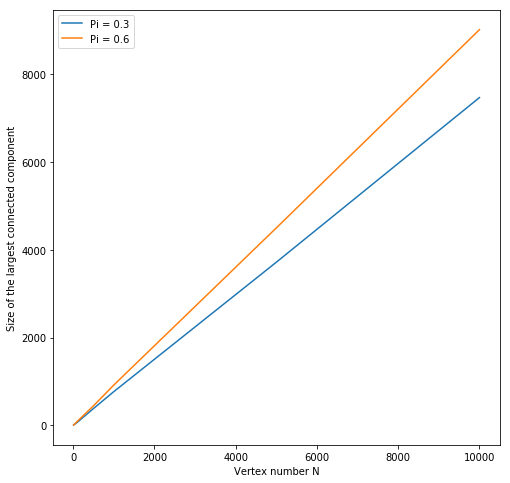

In [83]:
plt.clf()
plt.figure(figsize=(8,8))
plt.plot(N,estimate_size_list_pi_3,label='Pi = 0.3')
plt.plot(N,estimate_size_list_pi_6,label='Pi = 0.6')
plt.xlabel('Vertex number N')
plt.ylabel('Size of the largest connected component')
plt.legend()
plt.show()

In [84]:
print(estimate_size_list_pi_3)
print(estimate_size_list_pi_6)

[8.0, 70.0, 385.0, 769.2, 3716.4, 7466.0]
[8.6, 91.6, 447.2, 920.0, 4497.6, 9012.6]


We observe that the size of the largest connected component increases linearly with the vertex number $N$ which infers that the normalized size is independant of the size of the graph and should depend only on $\pi$. Let's verify it:

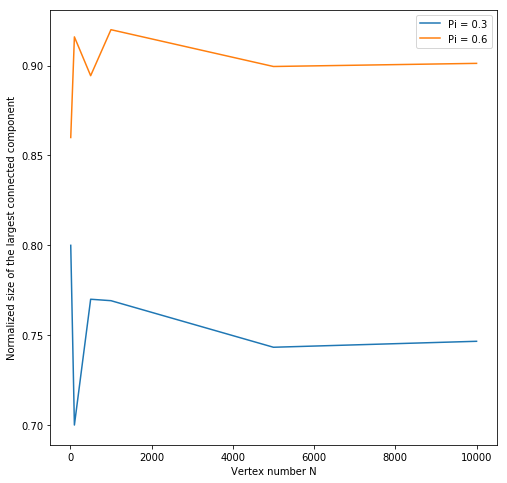

In [89]:
norm_estimate_pi_3 = []
norm_estimate_pi_6 = []
for i in range(len(N)):
    norm_estimate_pi_3.append(estimate_size_list_pi_3[i]/N[i])
    norm_estimate_pi_6.append(estimate_size_list_pi_6[i]/N[i])
plt.clf()
plt.figure(figsize=(8,8))
plt.plot(N,norm_estimate_pi_3,label='Pi = 0.3')
plt.plot(N,norm_estimate_pi_6,label='Pi = 0.6')
plt.xlabel('Vertex number N')
plt.ylabel('Normalized size of the largest connected component')
plt.legend()
plt.show()

Indeed, the normalized size of the largest connected component seems to be constant for large values of $N$. The fluctuations at small $N$ are finite-size related and the average over a larger number of graphs should solve the problem.

*(c) Plot the resuts of (a) and (b) in a single figure*

Let's compare the results found analytically in the question (a) and numerically in the question (b).
To do so, we need to compute the size of the largest connected component in graphs for a bigger number of values of $\pi$. For the sake of time calculation, we will use the constant value $N = 5000$ and compute the average size over 5 invidual graphs for each values of $\pi$.

In [ ]:
N = 5000
number_graph = 5
pi = np.linspace(0,1,40)
estimate_size = []
for i in range(len(pi)):
    print('Pi:',pi[i])
    size = 0
    for j in range(number_graph):
        M = generate_graph(N,pi[i],10000)
        size += largest_connected_component(M)
    estimate_size.append(size / (N*number_graph)) 

In [92]:
print(estimate_size)

[0.0004, 0.0038, 0.01188, 0.05916, 0.182, 0.26524, 0.34068, 0.40784, 0.46676, 0.52284, 0.5626, 0.60344, 0.6462, 0.67348, 0.699, 0.73376, 0.75596, 0.78996, 0.81384, 0.83056, 0.84868, 0.861, 0.87912, 0.8908, 0.91172, 0.91976, 0.93672, 0.9448, 0.95492, 0.9606, 0.96988, 0.9746, 0.98272, 0.98568, 0.99028, 0.99412, 0.99676, 0.99836, 0.9996, 0.99992]


Let's compare the numerical and analytical results.

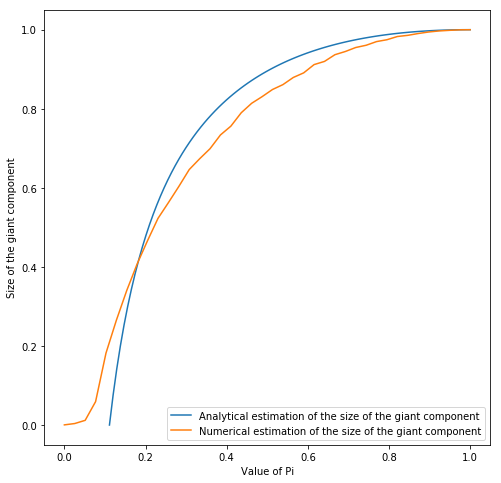

In [93]:
plt.clf()
plt.figure(figsize=(8,8))
plt.plot(pi_list,S,label='Analytical estimation of the size of the giant component')
plt.plot(pi,estimate_size,label='Numerical estimation of the size of the giant component')
plt.xlabel('Value of Pi')
plt.ylabel('Size of the giant component')
plt.legend()
plt.show()

The numerical estimation shows that there is a threshold above which the largest connected component grows with the value of $\pi$. The behavior is then similar to the analytical estimation and tends to 1 when $\pi$ tends to 1 as well. However, this value is lower than the one we predicted analytically: $\pi_c \approx 0.04$ instead of $\pi_c \approx 0.11$. This could be due to the fact that the growth of the graph is not perfect and our algorithm fails to endorse strictly the vertex degree distribution. Indeed, a look to the adjacency matrices shows that there is a small portion of nodes whose degree is equal to $2$ (0.002% of the population) or $3$ (0.012% of the nodes). However, the derivation of the analytical model identifies the vertex degree distribution with the actual proportion of different vertex degree. Thus, we should observe some discrepancies between the two results as even the proportions of degree 1 and 4 are $1 - \pi$ and $\pi$ in *average*. More generally, most of the quantities used in the analytical model are average values so the size of the graphs ($N = 5000$) might not be large enough to reduce fluctuations and leads to finite-size effects. Finally, the constraint on self-edges and multiedges might also affect the results.

## Problem 3: Emergence of the 3-core

*(a) Generalize the analytical calculation for the dynamics of the 3-core algorithm from $G(N,c/N)$ to our graph ensemble. Determine the critical threshold $\pi$ for the emergence of the 3-core. Is the transition continuous or not? What is the size of the 3-core just after the transition?*

It is possible to describe the dynamics of a q-core algorithm using the *rate equations* for the degree distribution. We use a stochastic version of the algorithm:
* Select randomly one vertex of degree lower than $q$
* Remove it and all its incident edges
We rescale the algorithmic time $T = 0, ..., N$ to $t = T/N \in [0,1]$. It corresponds to the fraction of removed vertices.
* Number of remaining vertices at time $t$: $N(t) = (1 - t).N$
* Number of remaining vertices of degree $d$ at time $t$: $N_d(t)$ and $p_d(t) = N_d(t) / N(t)$.

The algorithm has two effects which are removing a vertex and reducing the degree of all neighbors by one.

We introduce:

* $\chi_d = 1$ if $d < q$ or $0$ otherwise,
* $\overline{\chi} = \sum_d p_d(t). \chi_d$, i.e. the fraction of nodes with degree lower than $q$,
* $c(t) = \sum_d d .p_d(t)$,
* $\overline{d\chi} = \sum_d d.\chi_d . p_d(t)$.

By taking into account the two effects of the algorithm, we obtain:

$$N_d(t+\Delta t)-N_d(t)= - \frac{\chi_d.p_d(t)}{\overline{\chi}} + \frac{\overline{d\chi}}{\overline{\chi}}[-\frac{d.p_d(t)}{c(t)}+\frac{(d+1)p_{d+1}}{c(t)}]$$

By taking the limit $N >> 1$ and $\Delta t \rightarrow 0$, we have:
$$N_d(t+\Delta t)-N_d(t) = \frac{d}{dt}((1-t).p_d(t))$$
Hence:
$$\frac{d}{dt}((1-t).p_d(t)) = - \frac{\chi_d.p_d(t)}{\overline{\chi}} + \frac{\overline{d\chi}}{\overline{\chi}}[-\frac{d.p_d(t)}{c(t)}+\frac{(d+1)p_{d+1}}{c(t)}]$$

We solve numerically the system of 5 coupled differential equations for $d = 0, ..., 4$.

In [104]:
def vectorfield(t, w):
    
    p0, p1, p2, p3, p4 = w

    c = p1 + 2*p2 + 3*p3 + 4*p4
    chi = p0 + p1 + p2
    d_chi = p1 + 2*p2
    
    a = 1/(1-t)
    
    f = [a*(p0 - p0/chi + (d_chi*p1)/(chi * c)),
        a*(p1 - p1/chi + (d_chi/chi)*(-p1/c + 2*p2/c)),
        a*(p2 - p2/chi + (d_chi/chi)*(-2*p2/c + 3*p3/c)),
        a*(p3 + (d_chi/chi)*(-3*p3/c + 4*p4/c)),
        a*(p4 + (d_chi/chi)*(-4*p4/c))]
    
    return f

In [147]:
from scipy.integrate import ode

# ODE solver parameters
stoptime = 0.9
dt = 0.005

# Case 1 for pi < pi_critical
pi = 0.4

p0 = 0
p1 = 1 - pi
p2 = 0
p3 = 0
p4 = pi


# Pack up the initial conditions:
w0 = [p0, p1, p2, p3, p4]

# Call the ODE solver.
solver = ode(vectorfield).set_integrator('vode',nsteps=500,method='bdf')
solver.set_initial_value(w0, 0)

# Solve
t = []
wsol_0 = np.zeros((int(stoptime/dt),5))
i = 0
while solver.successful() and solver.t < stoptime:
    t.append(solver.t+dt)
    wsol_0[i] = solver.integrate(solver.t+dt)
    i += 1

# Case 2 for pi > pi_c

pi = 0.7

p0 = 0
p1 = 1 - pi
p2 = 0
p3 = 0
p4 = pi

# Pack up the initial conditions:
w0 = [p0, p1, p2, p3, p4]

# Call the ODE solver.
solver = ode(vectorfield).set_integrator('vode',nsteps=500,method='bdf')
solver.set_initial_value(w0, 0)

# Solve
t = []
wsol_1 = np.zeros((int(stoptime/dt),5))
i = 0
while solver.successful() and solver.t < stoptime:
    t.append(solver.t+dt)
    wsol_1[i] = solver.integrate(solver.t+dt)
    i += 1

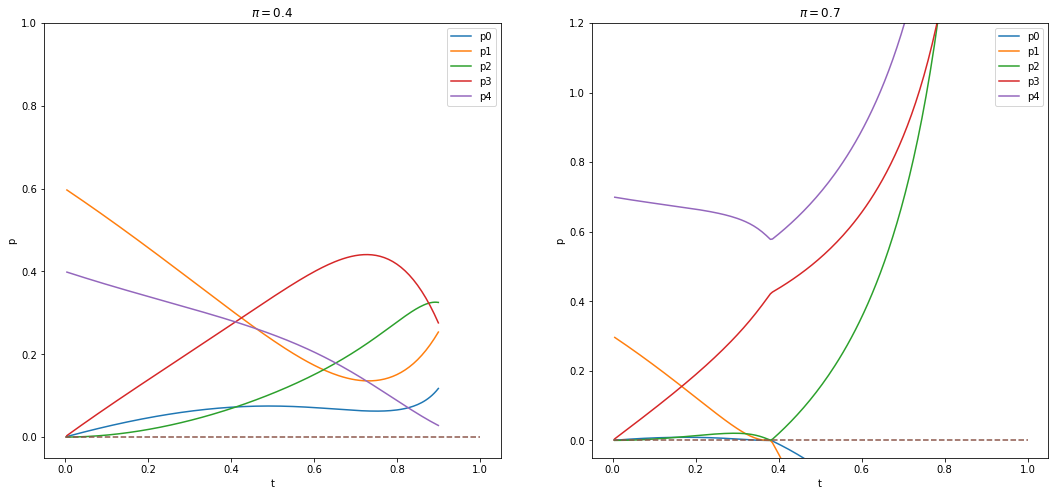

In [148]:
plt.clf()
plt.figure(figsize=(18,8))
plt.subplot(121)
axes = plt.gca()
axes.set_ylim([-0.05,1])
for i in range(5):
    plt.plot(t,wsol_0[:,i], label='p'+str(i))
plt.plot([0,1],[0,0],'--')
plt.xlabel('t')
plt.ylabel('p')
plt.title('$\pi = 0.4$')
plt.legend(bbox_to_anchor=(1, 1))
plt.subplot(122)
axes = plt.gca()
axes.set_ylim([-0.05,1.2])
for i in range(5):
    plt.plot(t,wsol_1[:,i], label='p'+str(i))
plt.plot([0,1],[0,0],'--')
plt.xlabel('t')
plt.ylabel('p')
plt.title('$\pi = 0.7$')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

We observe that there are two different regimes. For small values of $\pi$, all the probabilities are different than $0$ for $t \ne 0$. Actually, $p_d \longrightarrow 0$ for $d > 0$ when $t$ tends to $1$. However, for higher values of $\pi$, there seems to be a critical time $t_c \ne 0$ for which $p_d(t_c) = 0$ for $d \leq 2$: this is a characteristic of the appearance of the 3-core. The curves for $t > t_c$ does not represent anything physical as the algorithm has already stopped.
Hence, we choose to solve the coupled ODEs for different values of $\pi$ in order to find the threshold for which there is a $t_c$ such as $p_2(t_c) = 0$. It will give us the critical value of $\pi$. The size of the 3-core will be $S = 1 - t_c$.

In [171]:
# ODE solver parameters
stoptime = 0.9
dt = 0.005

for pi in np.arange(0.6,0.7,0.001):

    p0 = 0
    p1 = 1 - pi
    p2 = 0
    p3 = 0
    p4 = pi

    # Pack up the initial conditions:
    w0 = [p0, p1, p2, p3, p4]

    # Call the ODE solver.
    solver = ode(vectorfield).set_integrator('vode',nsteps=500,method='bdf')
    solver.set_initial_value(w0, 0)

    # Solve
    t = []
    wsol = np.zeros((int(stoptime/dt),5))
    i = 0
    while solver.successful() and solver.t < stoptime:
        t.append(solver.t+dt)
        wsol[i] = solver.integrate(solver.t+dt)
        i += 1
        
    min_p2 = np.min(wsol[40:,2]) # we start looking at t > 0.2 to ignore behavior close to small times
    threshold = 5e-4
    if min_p2 < threshold:
        tc = 40*dt+np.argmin(wsol[40:,2])*dt
        print('Critical value reached for pi =',pi, 'at time t =',tc)
        print('Relative size of the 3-core:',1-tc)
        break

Critical value reached for pi = 0.667 at time t = 0.5
Relative size of the 3-core: 0.5


C:\Users\Swag\Documents\WinPython-64bit-3.6.2.0Qt5\python-3.6.2.amd64\lib\site-packages\scipy\integrate\_ode.py:869: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  'Unexpected istate=%s' % istate))


We find a critical value for $\pi$ which is equal to $\pi_c = 0.667$. The size after the transition is $S = 0.5$.

*(b) Compare the analytical results of (a) with a direct implentation of the 3-core algorithm for specific graph instances.*

The algorithm is very simple. During the first round, we delete all vertices with degrees at most $q-1 = 2$ as they do not belong to the 3-core. As vertices are deleted, some others may become light i.e. their degrees can become lower than $3$ because of the loss of neighbors. At the next round, we delete all the light vertices in the remaining graph and so on. The algorithm is stopped when either all the vertices in the final graph have degrees at least $3$ or the graph is empty (i.e. there is no 3-core in the graph).

In [58]:
def k_core_algorithm(M,k):
    
    matrix = copy.deepcopy(M)
    V = np.sum(matrix, axis = 1)
    # Light vertex (degree < k) - init
    L = np.where(V < 3)[0]
    while len(L) > 0:
        
        l = L[0]
        L = np.delete(L,0)
        V[l] = 0
        row = M[l,:]
        neighbors = np.where(row > 0)[0]
        for n in neighbors:
            matrix[l,n] = 0 # remove edge
            matrix[n,l] = 0
            if V[n] > 0:
                V[n] -= 1 # every neighbor loses 1 edge
                if V[n] < k and n not in L: 
                    L = np.append(L,[n]) 
    return matrix              

We test our algorithm to a graph with $N = 30$ vertices and $\pi = 0.7$.

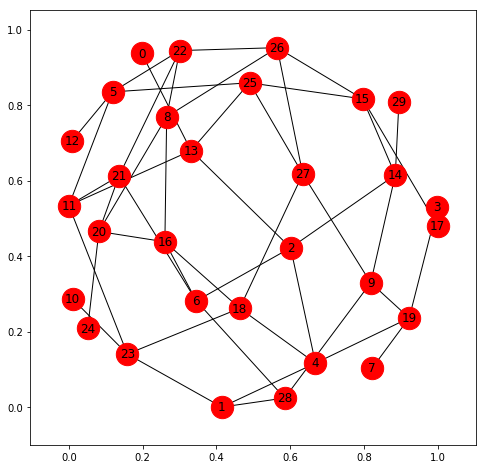

In [219]:
M = generate_graph(30, 0.7, 1000)
show_graph(M)

In [220]:
M_core = k_core_algorithm(M,3)

The degrees of the final graph became:

In [222]:
print(np.sum(M_core, axis = 1))

[ 0.  3.  4.  0.  3.  3.  4.  0.  4.  3.  0.  4.  0.  3.  3.  3.  4.  0.
  4.  0.  3.  4.  4.  3.  0.  4.  4.  4.  3.  0.]


All degrees are at least $k = 3$ if we consider than a zero degree corresponds to a vertex which has been deleted. Let's have a look at the final k-core graph:

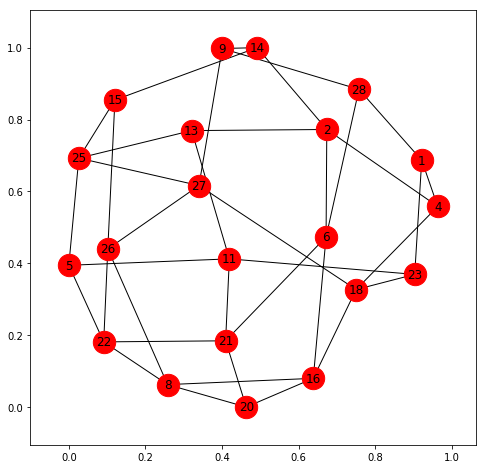

In [223]:
show_graph(M_core)

Let's now apply the k-core algorithm to several graphs with $N = 5000$ vertices but with different values of $\pi$ and let's plot the normalized size of the remaining 3-core graphs as a function of $\pi$.

In [76]:
N = 5000
size_k_core = []
pi_values = np.linspace(0,1,100)
for pi in pi_values :
    M = generate_graph(N,pi,20000)
    M_core = k_core_algorithm(M,3)
    degrees_list = np.sum(M_core, axis = 1)
    size = np.where(degrees_list > 0)[0].shape[0]
    size_k_core.append(size/N)

In [78]:
print(size_k_core)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5308, 0.5062, 0.586, 0.5414, 0.6146, 0.6204, 0.652, 0.6648, 0.6826, 0.6868, 0.7246, 0.7228, 0.7412, 0.7542, 0.7784, 0.7688, 0.7956, 0.8062, 0.8208, 0.8354, 0.845, 0.8578, 0.8658, 0.8832, 0.8836, 0.8984, 0.9108, 0.9348, 0.9392, 0.9444, 0.9572, 0.9632, 0.9794, 0.9852, 0.9964]


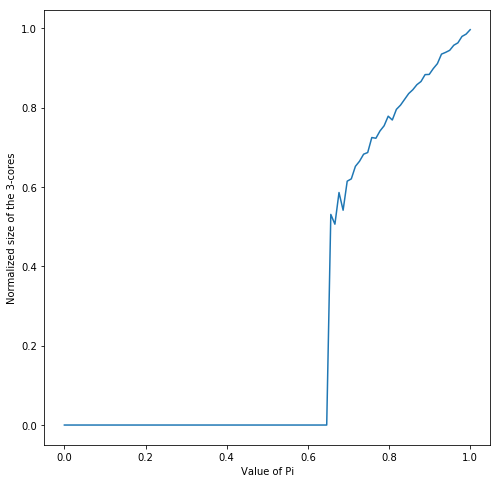

In [79]:
plt.clf()
plt.figure(figsize=(8,8))
plt.plot(pi_values,size_k_core)
plt.xlabel('Value of Pi')
plt.ylabel('Normalized size of the 3-cores')
plt.show()

Numerical simulations show the existence of a threshold for $\pi$ such that $\pi_c \approx 0.63$. Below this value, no 3-core exists in the graph. However, for $\pi \geq \pi_c$, we observe the sudden emergence of a 3-core with has already the size of $S = 0.53$ right after the transition. The phase transition appears to be non continous. Results from this simulation are very close to the one we found above for which $\pi_c = 0.667$ and the size after the transition was $S = 0.5$.

## Problem 4: The ferromagnetic Ising model

The ferromagnetic Ising model is given by the Hamiltonian $H$ such that
$H = - \sum_{(i,j) \in E} S_i S_j$ where the spins $i$ ($S_i = \pm 1$) and $j$ ($S_j = \pm 1$) are coupled if there is an edge bounding the two spins. Let's simulate the Ising model with a MCMC method for different temperatures and different values of $\pi$. We interpret the results by looking at the resulted histograms of the global magnetization $M = \frac{1}{N} \sum_i S_i$. We average the results over many equilibrium configurations of the model. In order to speed up the computation, we use Wolff algorithm (which is a particular case of cluster algorithms).

### Test of our code
Let's first be sure that our code works correctly by testing it with a graph such that $N = 30$ and $\pi = 0.7$.

In [226]:
N = 30
pi = 0.7
M_ising = generate_graph(N,pi,10000)

In [3]:
def init_spins(M):
    S = []
    length = M.shape[0]
    for i in range(length):
        S.append(2*np.random.randint(2)-1)
    return S

In [227]:
S_init = init_spins(M_ising)

In [4]:
def cluster(M,S,T,J):
    
    p = 1 - np.exp(-2*J/T)
    m = int(len(S)*np.random.random()) # pick a random site
    C = [m] # cluster
    row = M[m,:]
    neighbors = np.where(row > 0)[0]
    neighbors_tmp = []
    while len(neighbors) > 0:
        
        neighbors_tmp = []
        sitesToDelete = []
        
        for k in neighbors:
            sitesToDelete.append(k)
            if k not in C:
                if S[m] == S[k]:
                    if np.random.random() < p: # if k has same spin than m, we add it to the cluster with prob. p
                        C.append(k)
                        row = M[k,:]
                        neighbors_k = np.where(row > 0)[0]
                        for j in neighbors_k:
                            neighbors_tmp.append(j)
                        
        for l in sitesToDelete:
            indice = np.where(neighbors == l)[0]
            neighbors = np.delete(neighbors,indice)
            
        for l in neighbors_tmp:
            neighbors = np.append(neighbors,l)          
    return C  

In [228]:
C = cluster(M_ising,S,2,1)

In [5]:
def wolff_algorithm(M_ising,S,N_steps,T,J):
    spins = copy.deepcopy(S)
    for i in range(N_steps):
        C = cluster(M_ising,spins,T,J)
        for k in C:
            spins[k] *= -1
    return spins

Initially, the graph looks like (where a blue node is associated to a spin -1 and a red one is associated to +1):

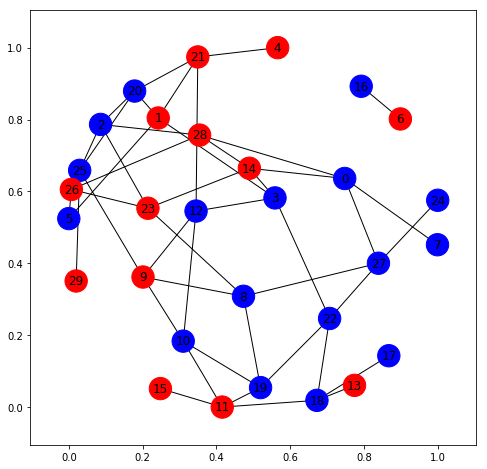

In [229]:
show_graph(M_ising,S_init)

Let's equilibrate the system with two temperatures: $T = 0.5$ and $T = 4$.

For $T = 0.5$:

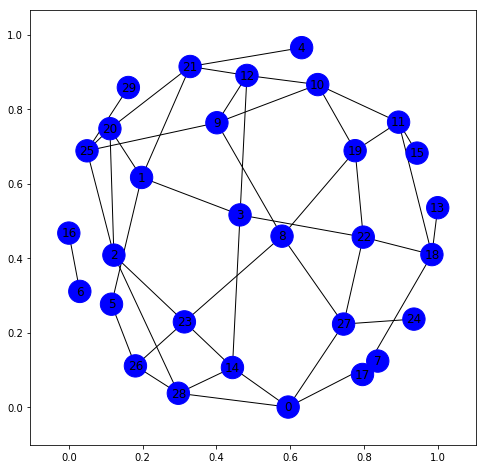

In [233]:
S_final_1 = wolff_algorithm(M_ising,S_init,1000,0.5,1)
show_graph(M_ising, S_final_1)

All the spins have the same sign which is coherent with a low temperature. We observe a ferromagnetic phase.
Now, for $T = 10$:

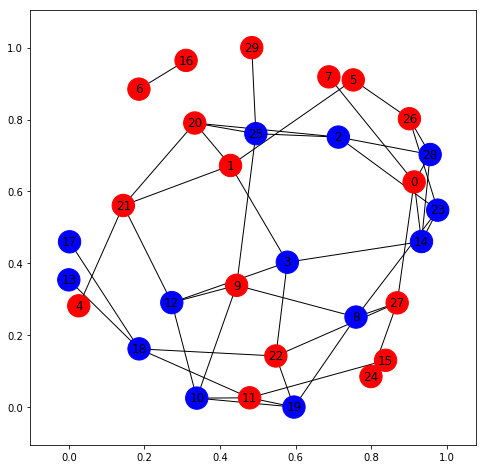

In [236]:
S_final_2 = wolff_algorithm(M_ising,S_init,1000,10,1)
show_graph(M_ising, S_final_2)

The graph looks now paramagnetic for this high temperature. 
### Histograms of global magnetization
We can now answer the initial question for graphs with $N = 500$ nodes. For each temperature $T \in [0.5, 1, 2.5, 5]$ and $\pi \in [0.2, 0.4, 0.6, 0.8, 1]$, we compute the equilibrated magnetization of $100$ different random graphs.

In [314]:
N = 500
N_iter = 100
J = 1
T = [0.5, 1, 2, 3, 5]
nb_t = len(T)
Pi = [0.2, 0.4, 0.6, 0.8]
nb_pi = len(Pi)
magnetization = np.zeros((nb_t,nb_pi,N_iter))

t_ind = 0
pi_ind = 0

t1 = time.time()
for t in T:
    for pi in Pi:
        for n in range(N_iter):
            M = generate_graph(N,pi,1000)
            S_init = init_spins(M)
            S_final = wolff_algorithm(M,S_init,500,t,J)
            magnetization[t_ind,pi_ind,n] = (1/N)*np.sum(S_final)
        pi_ind += 1
    t_ind += 1
    pi_ind = 0
    
t2 = time.time()

print('The process took ',t2-t1, 'seconds.')

The process took  13947.436158180237 seconds.


In [ ]:
print(np.absolute(magnetization))

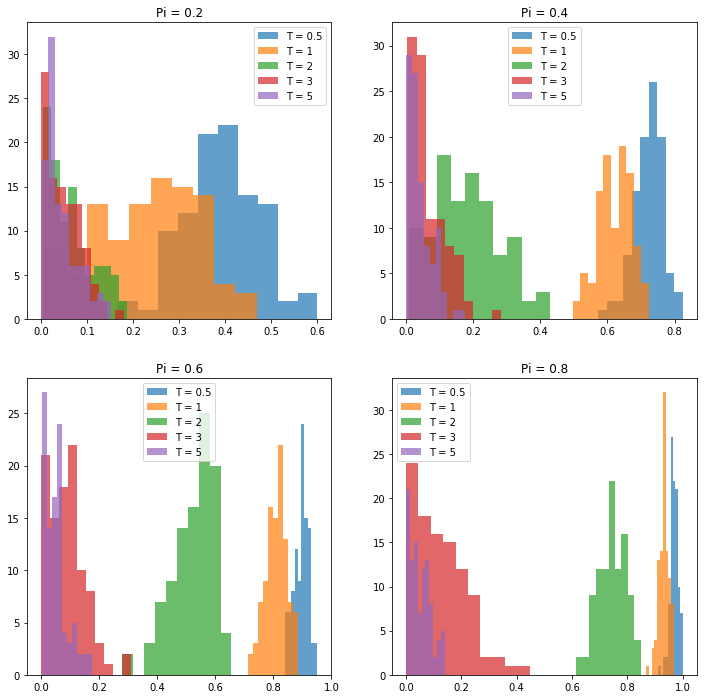

In [315]:
abs_magn = np.absolute(magnetization)
plt.clf()
plt.figure(figsize=(12,12))
for i in range(len(Pi)):
    pos = int('22'+str(i+1))
    plt.subplot(pos)
    for j in range(len(T)):
        plt.hist(abs_magn[j,i,:],alpha=0.7,label='T = '+str(T[j]))
        plt.title('Pi = '+str(Pi[i]))
    plt.legend()
plt.show()  

The histograms reveals that for all values of $\pi$, the magnetization at $T = 0.5$ is always high ($\geq 0.5$), indicating a ferromagnetic phase whereas for $T \geq 3$, the magnetization is low and almost zero which is the characteristic of paramagnetic phase. Intermediary temperatures exhibit a different behavior as they seem to be in-between for different values of $\pi$. A look at the results is enough to assess approximately the temperature of phase transition. For $\pi = 0.2$, $T = 1$ seems to be already at the transition whereas $T = 2$ is a better approximation for other values of $\pi$. We can also observe the following relative order for the critical temperatures $T(\pi = 0.4) < T(\pi = 0.6) < T(\pi = 0.8)$. Simulations on more temperature points would allow to assess the critical temperature with better accuracy.

*(b) Implement the equations of belief propagation (BP) on specific instances of the random graph. Find the phase transition temperature, and compare the results of BP with the MC simulations.*

We define the parameter $\mu_{ji}(S_i)$ as the message about finding spin $i$ in a state $S_i$ considering that spin $i$ interacts only with spin $j$ i.e. we consider that the other neighboring spins $N(i)-j$ are removed. We define in the same way the probabilities $\mu_{ni}(S_i)$ for the other neighbors $n \in N(i)$. The BP algorithm goes as followed:
* Initialize a set of normalized probabilities $\left\{\mu_{ji}(S_i)\right\}$.
* Choose two neighboring vertices $i$ and $j$ and compute the probability that the spin $j$ is in a state $S_j$ knowing that the state of spin $i$ is fixed: $$\mu_{ji}^{updated}(S_i) = A \sum_{S_j \pm 1} e^{+\beta S_i S_j} .e^{+\beta S_j^{init} S_j}\prod_{n \in N(j) - i} \mu_{nj}^{old}(S_j) $$ where $A$ is a normalization constant so that $\sum_{S_i} \mu_{ji}(S_i) = 1$, the first exponential term corresponds to the interaction between $i$ and $j$. We consider the initial spin configuration to be the external field and it is represented in the second exponential. Finally, the product term takes into account the messages of all neighboring spins.

Iteratively, the algorithm should converge to the set of equilibrium probabilities $\left\{\mu_{ji}(S_i)\right\}$.
Finaly, the belief that the spin $i$ is in state $S_i$ is: $$b_i(S_i) = B.e^{\beta.S_i.S_i^{init}}.\prod_{n\in N(i)}\mu_{ni}(S_i) $$
where $B$ is a normalization constant such that $b_i(S_i = +1) + b_i(S_i = -1) = 1$.

In [6]:
def Neighbors(M,i):
    row = M[i,:]
    neighbors = np.where(row > 0)[0]
    return neighbors

In [7]:
def LBP(M,S_init,T,N_iter):
    # Initialize mu_ji probabilities
    N = M.shape[0]
    mu = np.zeros((N,N,2))
    beta = 1/T
    for i in range(N):
        neighbors = Neighbors(M,i)
        for j in neighbors:
            mu[i,j,0] = np.random.random()
            mu[i,j,1] = 1 - mu[i,j,0]
        
            mu[j,i,0] = np.random.random()
            mu[j,i,1] = 1 - mu[j,i,0]

    # Update mu
    for k in range(N_iter):
        i = np.random.randint(N)
        neighbors_i = Neighbors(M,i)
        num_neighbors = len(neighbors_i)
        if num_neighbors > 0:
            j = neighbors_i[np.random.randint(num_neighbors)]
            neighbors_j = Neighbors(M,j)
    
            # mu_ji_(Si = 1)
            mu_ji_Si_p1 = 0
            for Sj in [1, -1]:
                ind_Sj = int((Sj + 1) / 2)
                tmp_product = 1
                for n in neighbors_j:
                    if n != i:
                        tmp_product *= mu[n,j,ind_Sj]
        
                mu_ji_Si_p1 += np.exp(beta*1*Sj)*np.exp(beta*Sj*S_init[j])*tmp_product
        
            # mu_ji_(Si = -1)
            mu_ji_Si_m1 = 0
            for Sj in [1, -1]:
                ind_Sj = int((Sj + 1) / 2)
                tmp_product = 1
                for n in neighbors_j:
                    if n != i:
                        tmp_product *= mu[n,j,ind_Sj]
                
                mu_ji_Si_m1 += np.exp(beta*-1*Sj)*np.exp(beta*Sj*S_init[j])*tmp_product
        
            A = mu_ji_Si_m1 + mu_ji_Si_p1
            mu[j,i,1] = mu_ji_Si_p1/A
            mu[j,i,0] = mu_ji_Si_m1/A
        
    return mu

In [8]:
def belief(mu,S_init,T):
    N = mu.shape[0]
    b = np.zeros((N,2))
    beta = 1/T
    for i in range(N):
        for S_i in [1, -1]:
            ind = int((S_i+1)/2)
            b[i,ind] = np.exp(beta*S_init[i]*S_i)
            for n in Neighbors(M,i):
                b[i,ind] *= mu[n,i,ind]
        A = b[i,0] + b[i,1]   
        b[i,0] = b[i,0] / A
        b[i,1] = b[i,1] / A
        
    return b

In [9]:
def spins_final(b):
    N = b.shape[0]
    return [2*np.argmax(b[i,:])-1 for i in range(N)]

In [10]:
def spins_final_soft(b):
    N = b.shape[0]
    return [b[i,1]-b[i,0] for i in range(N)]

Let's consider a random graph with $N = 1000$ and $\pi = 0.6$. We apply the Belief Propagation algorithm in order to compute the final magnetization for several temperatures. We use two criteria:
* a "hard" criteria for which the final state of spin $i$ is the state that maximizes the belief i.e. $S_i^f = +1$ if $b_i(S_i = 1) > b_i(S_i = -1)$ or $S_i^f = -1$ otherwise
* a "soft" criteria for which the final state of spin $i$ is $<m_i> = (+1).b_i(S_i = +1) + (-1).b_i(S_i = -1) \in [-1,1]$

In [11]:
N = 1000
pi = 0.6
N_iter = 1000000
M = generate_graph(N,pi,5000)
S_init = init_spins(M)

magnetization = []
magnetization_soft = []

for T in np.arange(0.3,3,0.1):
    mu = LBP(M,S_init,T,N_iter)
    b = belief(mu,S_init,T)
    S_final = spins_final(b)
    S_final_soft = spins_final_soft(b)
    magn = np.abs(np.sum(S_final))/N
    magn_soft = np.abs(np.sum(S_final_soft))/N
    magnetization.append(magn)
    magnetization_soft.append(magn_soft)

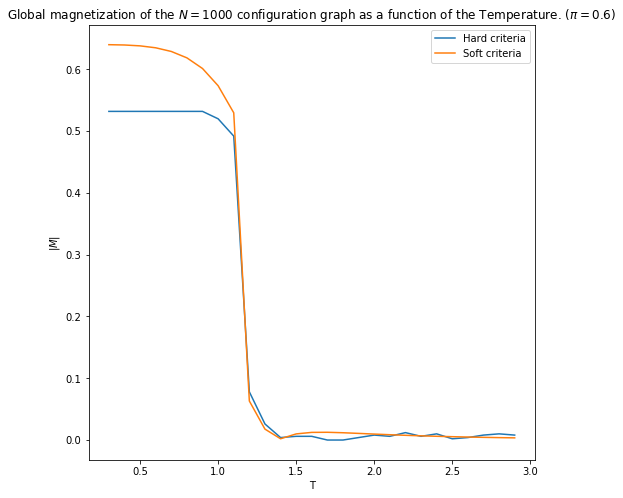

In [13]:
plt.clf()
plt.figure(figsize=(8,8))
plt.plot(np.arange(0.3,3,0.1),magnetization,label='Hard criteria')
plt.plot(np.arange(0.3,3,0.1),magnetization_soft,label='Soft criteria')
plt.xlabel('T')
plt.ylabel('$|M|$')
plt.legend()
plt.title('Global magnetization of the $N = 1000$ configuration graph as a function of the Temperature. ($\pi = 0.6$)')
plt.show()

The evolution of the magnetization as a function of the temperature allows us to compute the critical temperature. We can estimate $T_c \approx 1.4$. Furthermore, the BP algorithm has the advantage to be much faster than MCMC so it is possible to compute easily equilibrum configurations for a wider range of temperature: the computation of the critical temperature is, in turn, more accurate. However, one has to keep in mind that the BP is only exact for tree-like graphs: here, we need to consider the results as an approximation thanks to the local tree-like structure assumption.
Finally, we considered that the factor of a spin $i$ to be the thermal probability distribution: $\Psi_i(S_i) = \exp(\beta .H_i.S_i) = \exp(\beta .S_i.S_i^{init})$. Another model would have been to consider the local field $H_i$ such that $\Psi_i(S_i) = 
\exp(\beta .S_i.(\frac{1}{q})\sum_{k \in N(i)}S_k)$, with $q$ degree of spin $i$, i.e. the average field over the neigbhbors of $i$.

*(c) Determine the ensemble-averaged distribution of effective fields using the population-dynamics algorithm, and the corresponding ensemble-averaged phase diagram, generalizing the analytical calculations done in the lectures for random graphs.*

We can use the results of the BP algorithm in order to compute the ensemble-averaged distribution of effective fields. We can parametrize each message $\mu_{ij}$ by a single real number $\nu_{ij}$ such that:
$$\nu_{ij} = \tanh^{-1}(\mu_{ij}(S_i = +1) - \mu_{ij}(S_i = -1))$$

In this condition, the cavity field can be written: $h_{i\backslash j} = (1\backslash \beta).\sum_{j \in N(i) \backslash j} \nu_{ki}$. Each cavity field $h_{i\backslash j}$ is the effective field that acts on spin $i$ in the absence of spin $j$. Thanks to these, we can define the local *effective* field $h_i$ such that: 
$$h_i = \frac{1}{2\beta}\sum_{j \ \in N(i)} \ln\frac{\cosh(\beta.(h_{j\backslash i}+1))}{\cosh(\beta.(h_{j \backslash i}-1))} $$

We can directly use the converged cavity field population obtained with the BP algorithm in order to compute the distribution of effective fields.

In [11]:
def Nu(M,mu):
    N = mu.shape[0]
    nu = np.zeros((N,N))
    for i in range(N):
        for j in Neighbors(M,i):
            nu[i,j] = 1/(np.tanh(mu[i,j,1]-mu[i,j,0]))
    return nu

In [12]:
def H_cavity(M,nu,T):
    N = nu.shape[0]
    h_cavity = np.zeros((N,N))
    for i in range(N):
        neigh = Neighbors(M,i)
        for j in neigh:
            for k in neigh:
                if k != j:
                    h_cavity[i,j] += T*nu[k,i]
    return h_cavity

In [13]:
def H_effective(M,h_cavity,T):
    N = M.shape[0]
    h = np.zeros(N)
    beta = 1/T
    for i in range(N):
        for j in Neighbors(M,i):
            if beta*np.abs(h_cavity[j,i]) > 500:
                # To avoid overflow of cosh
                sgn = np.sign(h_cavity[j,i])
                h[i] += (T/2)*np.log(np.cosh(200*sgn)/np.cosh(200*sgn))
            else:
                h[i] += (T/2)*np.log(np.cosh(beta*(h_cavity[j,i]+1))/np.cosh(beta*(h_cavity[j,i]-1)))
    return h

Let's first have a look on the effective fields distribution for one specific instance of a graph with $N = 1000$ nodes and $\pi = 0.6$ for two temperatures: $T = 1$ and $T = 4$.

In [29]:
N = 1000
pi = 0.6
N_iter = 1000000
T = [1, 4]

M = generate_graph(N,pi,5000)
S_init = init_spins(M)

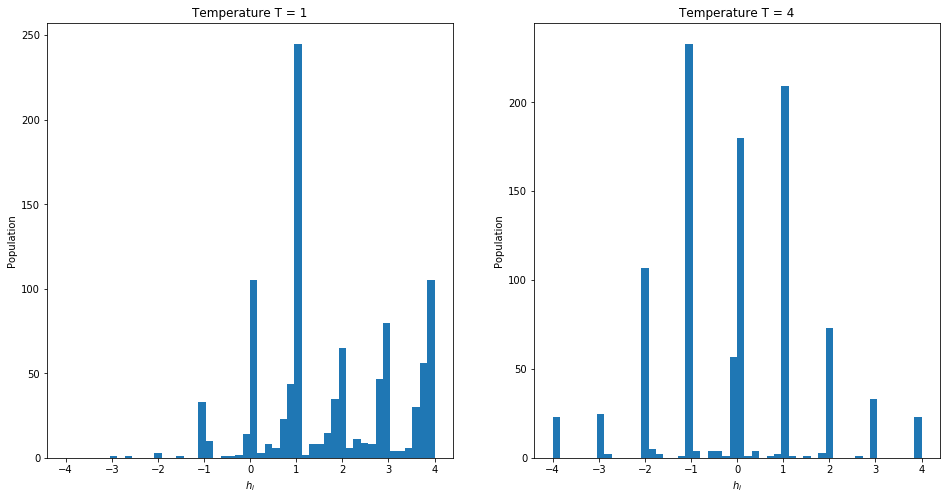

In [30]:
plt.clf()
plt.figure(figsize=(16,8))
for i in range(len(T)):
    mu = LBP(M,S_init,T[i],N_iter)
    nu = Nu(M,mu)
    h_cavity = H_cavity(M,nu,T[i])
    h = H_effective(M,h_cavity,T[i])
    plt.subplot('12'+str(i+1))
    plt.hist(h,bins = 50,range=(-4,4))
    plt.xlabel('$h_i$')
    plt.ylabel('Population')
    plt.title('Temperature T = '+str(T[i]))
plt.show()

Effective fields are strongly located on integer values of magnetization. The histogram on the left is characteristic of a ferromagnetic configuration as the population of effective fields is almost entirely situated on positive values. As for the histogram on the right, the symmetric aspect of the distribution reveals that the system is in a paramagnetic phase. Let's plot the phase diagram $h(T,\pi)$ by computing the average effective fields for 14 values of $\pi$ and 32 values of $T$. The boundary is computed thanks to a SVM classifier with a polynomial kernel: for each pair $(\pi,T)$, we assign the value $0$ if the average effective field is lower than $0.15$ (paramagnetic) or $1$ otherwise (ferromagnetic).

In [ ]:
N = 500
N_iter = 1000000
T = np.arange(0.3,3.5,0.1)
Pi = np.arange(0.2,0.9,0.05)
magnetization_dgm = np.zeros((len(Pi),len(T)))
for i in range(len(Pi)):
    print('Pi = ',Pi[i])
    pi = Pi[i]
    M = generate_graph(N,pi,5000)
    S_init = init_spins(M)
    for j in range(len(T)):
        t = T[j]
        mu = LBP(M,S_init,t,N_iter)
        nu = Nu(M,mu)
        h_cavity = H_cavity(M,nu,t)
        h = H_effective(M,h_cavity,t)
        magnetization_dgm[i,j] = np.absolute(np.sum(h))/len(h)

In [59]:
FM = np.zeros_like(magnetization_dgm)
for i in range(len(Pi)):
    for j in range(len(T)):
        if np.abs(magnetization_dgm[i,j]) < 0.15:
            FM[i,j] = 0
        else:
            FM[i,j] = 1

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])

In [17]:
x0, x1 = np.meshgrid(T, Pi)
X = np.c_[x0.ravel(), x1.ravel()]
X_bis = np.c_[X[:,1],X[:,0]]

In [61]:
poly_kernel_svm_clf.fit(X_bis, FM.ravel())

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=5, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [19]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

In [20]:
def plot_data(X,y,axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')

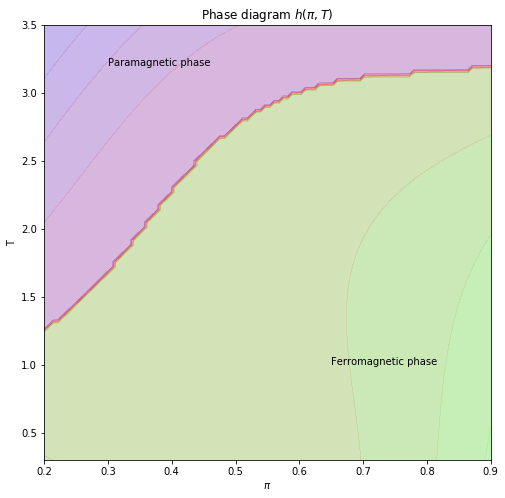

In [64]:
plt.clf()
plt.figure(figsize=(8,8))
plot_predictions(poly_kernel_svm_clf,[0.2,0.9,0.3,3.5])
#plot_data(X_bis,FM.ravel(),[0.2,0.9,0.3,3.5])
plt.text(0.3,3.2,'Paramagnetic phase')
plt.text(0.65,1,'Ferromagnetic phase')
plt.xlabel('$\pi$')
plt.ylabel('T')
plt.title('Phase diagram $h(\pi,T)$')
plt.show()

We observe a monotonous decision boundary between the paramagnetic phase and the ferromagnetic one. Hower, one should use many more graph configurations in order to get a more accurate phase diagram.

To get the analytical phase diagram we used some linear stability analysis :  We write $P(h)$ as :
$$ P(h) = \sum_{d=0}^{\infty} q_{d+1} \int dh_1 \ldots dh_d P(h_1) \ldots P(h_d) \delta(h - \sum_{l=1}^{\infty} \frac{1}{2 \beta} \ln \frac{\cosh(\beta (h_l +1 )}{\cosh(\beta (h_l -1)})$$ 

with $q_d$ being the exceed degree distribution $q_d = \frac{d p_d}{c}= \frac{d p_d}{3 \pi +1} $ 

   This recursive admits a trivial solution, the paramagnetic phase, $P(h) = \delta(h)$. The non-trivial solution is obtained by performing a linear stability analysis. On the rhs, we plug some function $P_0(h)$ which as a small but non-zero mean $\epsilon_0 = \int dh h P_0(h) $ and we then calculate the mean by iteration : 
   $$ \epsilon_1 = \int dh h P_1(h) $$
   $$ \epsilon_1 = \sum_{d=0}^{\infty} q_{d+1} \int dh_1 \ldots dh_d P_0(h_1) \ldots P_0(h_d)(\sum_{l=1}^{\infty} \frac{1}{2 \beta} \ln \frac{\cosh(\beta (h_l +1 )}{\cosh(\beta (h_l -1)}) $$
   $$ \epsilon_1 = \int dh P_0(h) \frac{1}{2 \beta} \ln \frac{\cosh(\beta (h_l +1 )}{\cosh(\beta (h_l -1)}) (\sum_{d=0}^{\infty} q_{d+1} d) $$
  $$ \epsilon_1 = \int dh P_0(h) \frac{1}{2 \beta} \ln \frac{\cosh(\beta (h_l +1 )}{\cosh(\beta (h_l -1)}) (\sum_{d=0}^{\infty} q_{d} (d-1)) $$
  
  Since we have 
  $$\frac{1}{2 \beta} \ln \frac{\cosh(\beta (h_l +1 )}{\cosh(\beta (h_l -1)} = h \tanh(\beta) +  \mathcal{O}(h)  $$
  $$ \sum_{d=0}^{\infty} q_{d} (d-1) =  0 + 3 q_4 = \frac{12 \pi}{3 \pi +1} $$
  
  We get :
  
  $$ \epsilon_1 = \frac{12 \pi}{3 \pi +1} tanh(\beta) \epsilon_0 $$
  
  The equation $ \frac{12 \pi}{3 \pi +1} tanh(\beta) =1 $ defines the border of the phase diagram : if the lhs is less than 1, then the iteration gives us back the trivial solution $\delta(h)$ otherwise we get another non-trivial solution, corresponding to the ferromagnetic phase. 
  An interesting point is that for $T=0$, since $ \lim_{x \rightarrow \infty} tanh(x) = 1 $ we have that the critical point is obtained for $\pi_c = 1/9$ which is in agreement with the fact that no phase transition can occur under this value since no giant conponent exist ! 

C:\Users\Swag\Documents\WinPython-64bit-3.6.2.0Qt5\python-3.6.2.amd64\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Swag\Documents\WinPython-64bit-3.6.2.0Qt5\python-3.6.2.amd64\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in arctanh
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Swag\Documents\WinPython-64bit-3.6.2.0Qt5\python-3.6.2.amd64\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in arctanh
  This is separate from the ipykernel package so we can avoid doing imports until


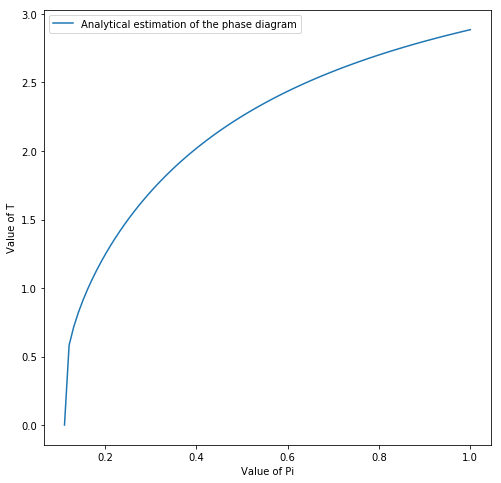

In [5]:
pi_list_2 = np.linspace(0,1,100)
u_list_2 = 12*pi_list_2/(3*pi_list_2 +1)
T_List = 1/np.arctanh(1/u_list_2)
plt.clf()
plt.figure(figsize=(8,8))
plt.plot(pi_list_2,T_List,label='Analytical estimation of the phase diagram')
plt.xlabel('Value of Pi')
plt.ylabel('Value of T')
plt.legend()
plt.show()

## Problem 5: Inverse Ising model and graph reconstruction

Use a large i.i.d. sample $\left\{S_i^m\right\}_{i=1,...,N}^{m=1,...,M}$ of configurations sampled from the Ising model in the paramagnetic phase to reconsruct the underlying graph.

*(a) Estimate the connected correlations $c_{ij} = <S_iS_j> - <S_i><S_j>$ from the samples, for all pairs $1 \leq i < j \leq N$. Sort the pairs according to their correlation, and determine the positive predictive value (number of true positive predicted edges / number of predictions) as a function of the number of predictions (strongest correlated pairs).*

We do so by generating a graph of $N = 500$ nodes with $\pi = 0.6$ at the temperature $T = 3.5$. We use MCMC methods (Wolff algorithm) to compute $M = 10000$ configurations at equilibrium.

In [7]:
N = 500
N_samples = 10000 # M
pi = 0.6
T = 3.5
M = generate_graph(N,pi,5000)
S_init = init_spins(M)
N_iter = 200
spins = np.zeros((N_samples,N))

for i in range(N_samples):
    S_final = wolff_algorithm(M,S_init,N_iter,T,1)
    spins[i,:] = S_final

In [8]:
C = np.zeros((N,N))
for i in range(N):
    for j in range(i+1,N):
        C[i,j] = (1/N_samples)*(np.asarray(spins[:,i]).dot(np.transpose(np.asarray(spins[:,j])))) - (1/N_samples**2)* np.sum(spins[:,i])*np.sum(spins[:,j])

In [9]:
A = np.argsort(C.reshape(1,-1)[0])
B = [(int(i/N),i%N) for i in np.flip(A,0)]

In [10]:
edges = np.zeros(N*N)
for i in range(len(B)):
    x = B[i][0]
    y = B[i][1]
    edges[i] = M[x,y]

In [11]:
num_pred = np.arange(1,N*(3*pi+1),10).astype(int)
predictive_value = [np.sum(edges[:i])/i for i in num_pred]

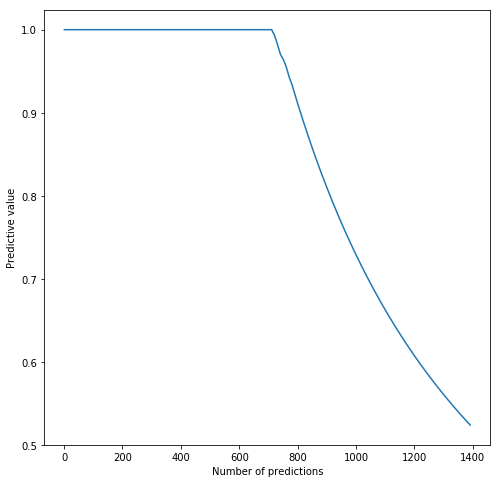

In [12]:
plt.figure(figsize=(8,8))
plt.plot(num_pred,predictive_value)
plt.xlabel('Number of predictions')
plt.ylabel('Predictive value')
plt.show()

There are approximately $N(3\pi+1)/2 = 700$ edges in the graph. By looking at the evolution of the predictive value as a function of the number of predictions, we note that all the pairs with the highest correlation do correspond to actual edge in the graph. We observe almost no fluctuation as we averaged the results over 10 000 configurations.

*(b) Use the mean-field approximation to infer the underlying graph.*

In the mean-field approximation, the magnetization of the Curie-Weiss model is given by the solution of the self-consistent equation:
$$m_i = \tanh(\sum_{j \ne i}\beta J_{ij}m_j + h_i) $$
If we consider the linear response, the corrections between the node $i$ and $j$ can be computed thanks to:
$$c_{ik} = \frac{\partial m_i}{\partial h_k} = (1 - m_i^2)(\sum_{j \ne i} \beta J_{ij} \frac{\partial m_j}{\partial h_k} + \delta_{ik}) = (1 - m_i^2)(\sum_{j \ne i} \beta J_{ij} c_{jk} + \delta_{ik}) $$
Hence, considering the correlations and magnetizations computed above, we can derive a set of equations for the $J_{ij}$'s:
$$\sum_{j \ne i} J_{ij} c_{jk} = \frac{1}{\beta}(- \delta_{ik} + c_{ik}/(1-m_i^2)) $$
By inverting the matrix of correlations $c$, we deduce:
$$J_{ij}^* = -(c^{-1})_{ij} + \frac{\delta_{ij}}{\beta(1-m_i^2)} \underset{i \ne j}{=} -(c^{-1})_{ij}$$

In [13]:
# We recompute the matrix of correlations so that we have the c_ii's
C_p = np.zeros((N,N))
for i in range(N):
    for j in range(i,N):
        C_p[i,j] = (1/N_samples)*(np.asarray(spins[:,i]).dot(np.transpose(np.asarray(spins[:,j])))) - (1/N_samples**2)* np.sum(spins[:,i])*np.sum(spins[:,j])
        C_p[j,i] = C_p[i,j]

In [15]:
inv_C_p = np.linalg.inv(C_p)
J = np.zeros((N,N))
for i in range(N):
    for j in range(i+1,N):
        J[i,j] = -inv_C_p[i,j]
        J[j,i] = J[i,j]

In [35]:
print(int(np.where(J > 0.1)[0].shape[0]/2), 'predicted edges.')
print('There are',int(len(np.where(M[J > 0.1] == 0)[0])/2),'false positive values.')
print('There are',int(len(np.where(M[J < 0.1] == 1)[0])/2), 'false negative values')

730 predicted edges.
There are 1 false positive values.
There are 0 false negative values


By considering the threshold $J = 0.1$, the mean-field approximation predicted $730$ edges between nodes among which only $1$ is false positive, i.e. the predicted edge does not exist in the real graph, and none are false negative, i.e. no edge that does not exist in the graph has been predicted. This method gives very good results for the Ising model in the paramagnetic phase. Even if we "had" to select a threshold value, the $730$ edges with the highest coupling almost all represent actual edge in the graph.

*c) Plot histograms for the estimated connected correlations annd the inferred couplings, separated into the cases of pairs connected by an edge in the graph, and unconnected pairs. What do you observe?*

In [17]:
X_pairs = np.where(M == 1)[0]
Y_pairs = np.where(M == 1)[1]
pairs = []
for i in range(X_pairs.shape[0]):
    pairs.append((X_pairs[i],Y_pairs[i]))

In [18]:
C_connected = [C_p[pairs[i][0],pairs[i][1]] for i in range(len(pairs))]
J_connected = [J[pairs[i][0],pairs[i][1]] for i in range(len(pairs))]

In [19]:
X_non_pairs = np.where(M == 0)[0]
Y_non_pairs = np.where(M == 0)[1]
non_pairs = []
for i in range(X_pairs.shape[0]):
    non_pairs.append((X_non_pairs[i],Y_non_pairs[i]))

In [20]:
C_non_connected = [C[non_pairs[i][0],non_pairs[i][1]] for i in range(len(non_pairs))]
J_non_connected = [J[non_pairs[i][0],non_pairs[i][1]] for i in range(len(non_pairs))]

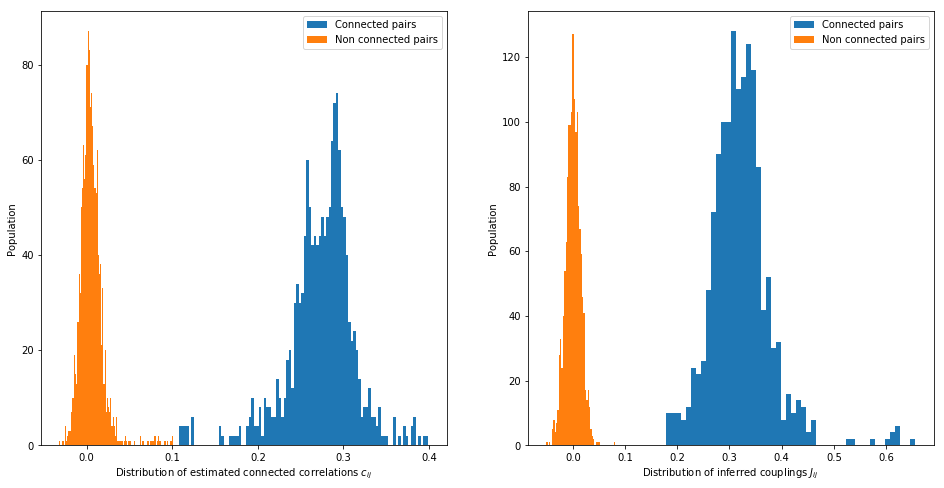

In [27]:
plt.clf()
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.hist(C_connected, bins = 100, label = 'Connected pairs')
plt.hist(C_non_connected, bins = 100, label = 'Non connected pairs')
plt.xlabel('Distribution of estimated connected correlations $c_{ij}$')
plt.ylabel('Population')
plt.legend()
plt.subplot(122)
plt.hist(J_connected, bins = 50, label = 'Connected pairs')
plt.hist(J_non_connected, bins = 50, label = 'Non connected pairs')
plt.xlabel('Distribution of inferred couplings $J_{ij}$')
plt.ylabel('Population')
plt.legend()
plt.show()

We observe that the distribution of $J_{ij}$'s are very well-separated . In particular, the threshold of $0.1$ we chose above is in the middle of the gap between the couplings corresponding to connected pairs and the ones corresponding to non-conneted pairs. It explains the good graph reconstruction we found above.